In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import emcee
import os

import sys
sys.path.insert(0, '../')

In [110]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from scipy.ndimage import median_filter as medfilt

n_cadences = 5#int(24 * 60 * 0.5) #  a day

def median_filter(x, n_cadences=n_cadences):
    return medfilt(x, (n_cadences, ))

import sys
sys.path.insert(0, '../')

import kplr
client = kplr.API()

names = 'Kepler-90'
koi_number = 1422

# Find the target KOI.
koi = client.koi(koi_number + 0.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for lc in lcs:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data
        time.append(hdu_data["time"] + 2454833)
        flux.append(hdu_data["sap_flux"])
        ferr.append(hdu_data["sap_flux_err"])
        quality.append(hdu_data["sap_quality"])

for time_q, flux_q, err_q in zip(time, flux, ferr):
    err_q /= np.nanmedian(flux_q)
    flux_q /= np.nanmedian(flux_q)
    not_nans = ~np.isnan(flux_q)
    p = np.polyfit(time_q[not_nans], flux_q[not_nans], 2)
    flux_q += 1 - np.polyval(p, time_q)

flux = median_filter(np.concatenate(flux))
not_nans = ~np.isnan(flux) & ~np.isnan(np.concatenate(time))
time = np.concatenate(time)[not_nans]
err = np.concatenate(ferr)[not_nans]/np.nanmax(flux)
flux = flux[not_nans]/np.nanmax(flux)

sort = np.argsort(time)
time = time[sort]
flux = flux[sort]
err = err[sort]

np.savetxt('k296_medfilt.txt', np.vstack([time, flux, err]).T)

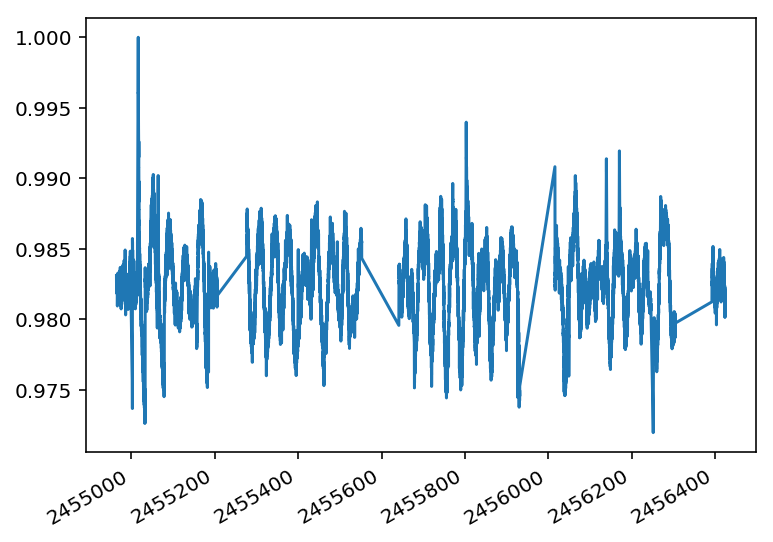

In [7]:
plt.plot(time, flux)
plt.setp(plt.gca().get_xticklabels(), rotation=30, ha='right');

(2455280, 2455380)

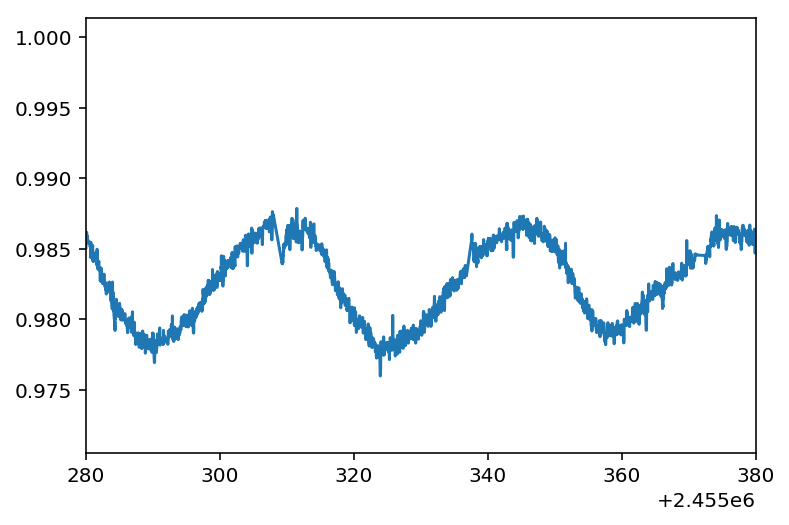

In [8]:
plt.plot(time, flux)
plt.xlim([2455280, 2455380])

In [94]:
rotation_period

36.085629155859351

(0, 70)

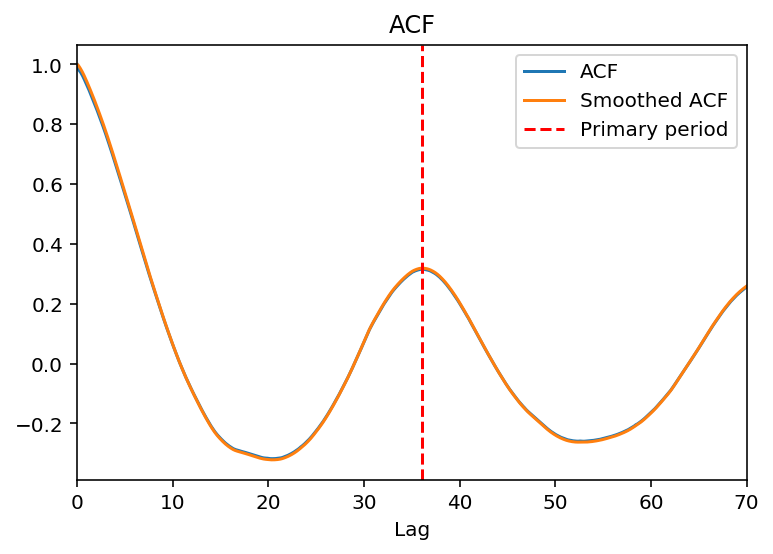

In [9]:
from interpacf import interpolated_acf, dominant_period

lag, acf = interpolated_acf(time, flux - np.median(flux))
rotation_period = dominant_period(lag, acf, plot=True)
plt.xlim([0, 70])

In [10]:
# slice in time
condition = (time > 2455280) & (time < 2455380)
chunk_time, chunk_flux, chunk_err = time[condition], medfilt(flux[condition], (10,)), err[condition]
chunk_flux /= np.percentile(chunk_flux, 98)
chunk_err[np.isnan(chunk_err)] = np.nanmedian(chunk_err)

<Container object of 3 artists>

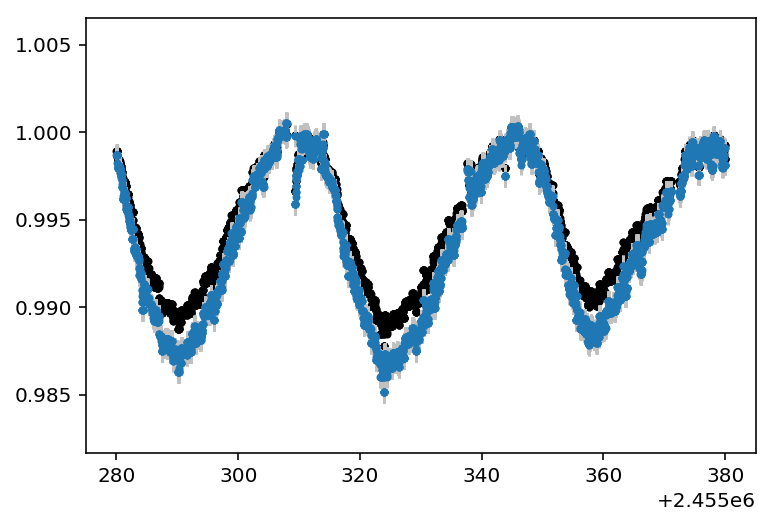

In [39]:

dilution_factor = 0.215

plt.scatter(chunk_time, chunk_flux, marker='.', color='k')

chunk_flux = (chunk_flux - 1) * (1 + dilution_factor) + 1

plt.errorbar(chunk_time, chunk_flux, chunk_err, fmt='.', ecolor='silver')

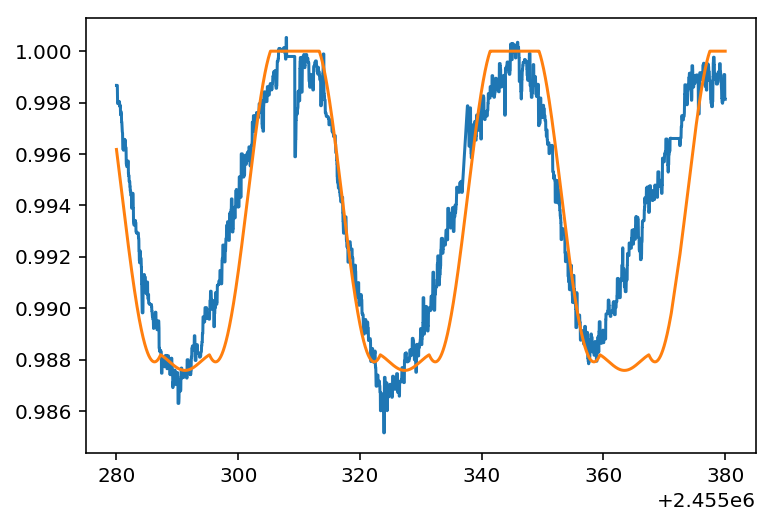

In [41]:
from libra import Spot, Star


spots = [Spot.from_latlon(0, 300, 0.18, contrast=0.7), 
         Spot.from_latlon(0, 200, 0.18, contrast=0.7)]

star = Star(spots=spots, rotation_period=rotation_period*u.day)
model_flux =  star.flux(chunk_time)
model_flux /= np.max(model_flux)

plt.plot(chunk_time, chunk_flux)
plt.plot(chunk_time, model_flux)


In [64]:
def model(p, time):
    lat0, lon0, rad0, lat1, lon1, rad1, contrast, kep_offset = p
    
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=contrast)]

    star = Star(spots=spots, rotation_period=rotation_period*u.day)
    model_flux = star.flux(time).value
    model_flux /= np.max(model_flux)
    model_flux += kep_offset

    return model_flux

def chi2(p, time):
    return np.sum((model(p, time) - chunk_flux)**2 / chunk_err**2)

from scipy.optimize import fmin_l_bfgs_b, fmin_powell


initp = np.array([  0, 200, 0.17, 
                    0, 290, 0.17, 
                    0.7, 0])

bounds = [[-90, 90], [0, 360], [0, 1],
          [-90, 90], [0, 360], [0, 1]]

# result0 = fmin_l_bfgs_b(chi2, initp, args=(chunk_time, ), approx_grad=True, bounds=bounds)[0]
# result1 = fmin_powell(chi2, initp, args=(chunk_time, ))

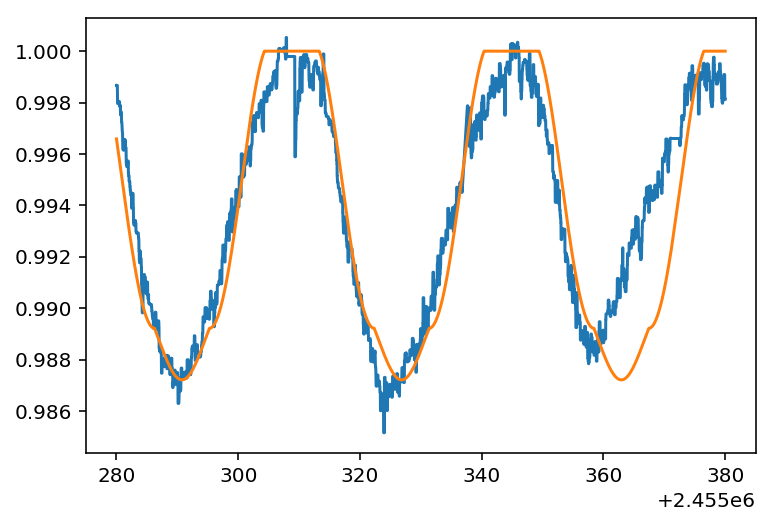

In [65]:
#%matplotlib notebook
plt.plot(chunk_time, chunk_flux)
plt.plot(chunk_time, model(initp, chunk_time))
# plt.plot(chunk_time, model(result1, chunk_time))

In [66]:
def lnprior(p):
    lat0, lon0, rad0, lat1, lon1, rad1, contrast, kep_offset = p
    lats = np.array([lat0, lat1])
    lons = np.array([lon0, lon1])
    rads = np.array([rad0, rad1])
    
    if np.any(lats < -90) or np.any(lats > 90):
        return -np.inf
    if np.any(lons < 0) or np.any(lons > 360):
        return -np.inf
    if np.any(rads < 0) or np.any(rads > 0.5):
        return -np.inf
    
#     if not (lon0 < 180 and 180 < lon1):
#         return -np.inf
    
    if not (0.2 < contrast < 0.9):
        return -np.inf
    return 0

def lnprob(p, time):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + -0.5*chi2(p, time)

ndim, nwalkers = 8, 20
pos = [initp + np.concatenate([1e-1*np.random.randn(ndim-1), [np.random.rand()]]) for i in range(nwalkers)]

In [80]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(chunk_time, ), 
                                threads=8)
sampler.run_mcmc(pos, 5000);

/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [106]:
n_burnin = 1000
samples = sampler.chain[:, n_burnin:, :].reshape((-1, ndim))

In [107]:
labels = ['lat', 'lon', 'rad', 'lat', 'lon', 'rad', 'contrast', 'kep_offset']

Text(0.5,0,'contrasts')

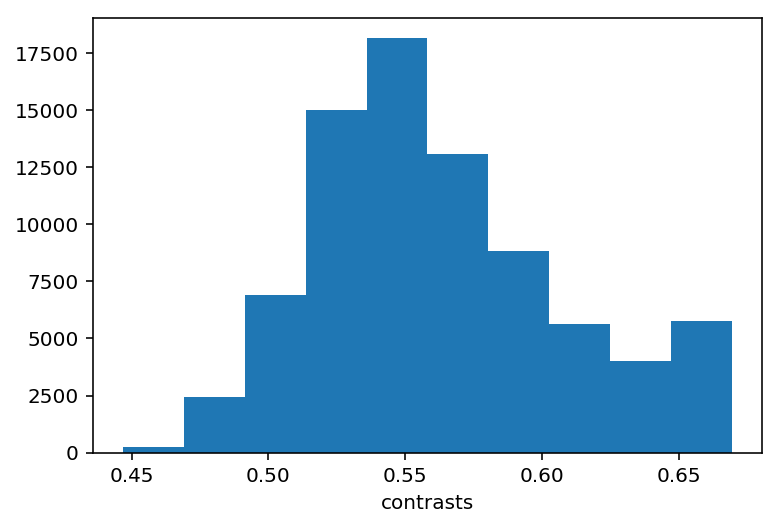

In [108]:
plt.hist(samples[:, -2])
plt.xlabel('contrasts')

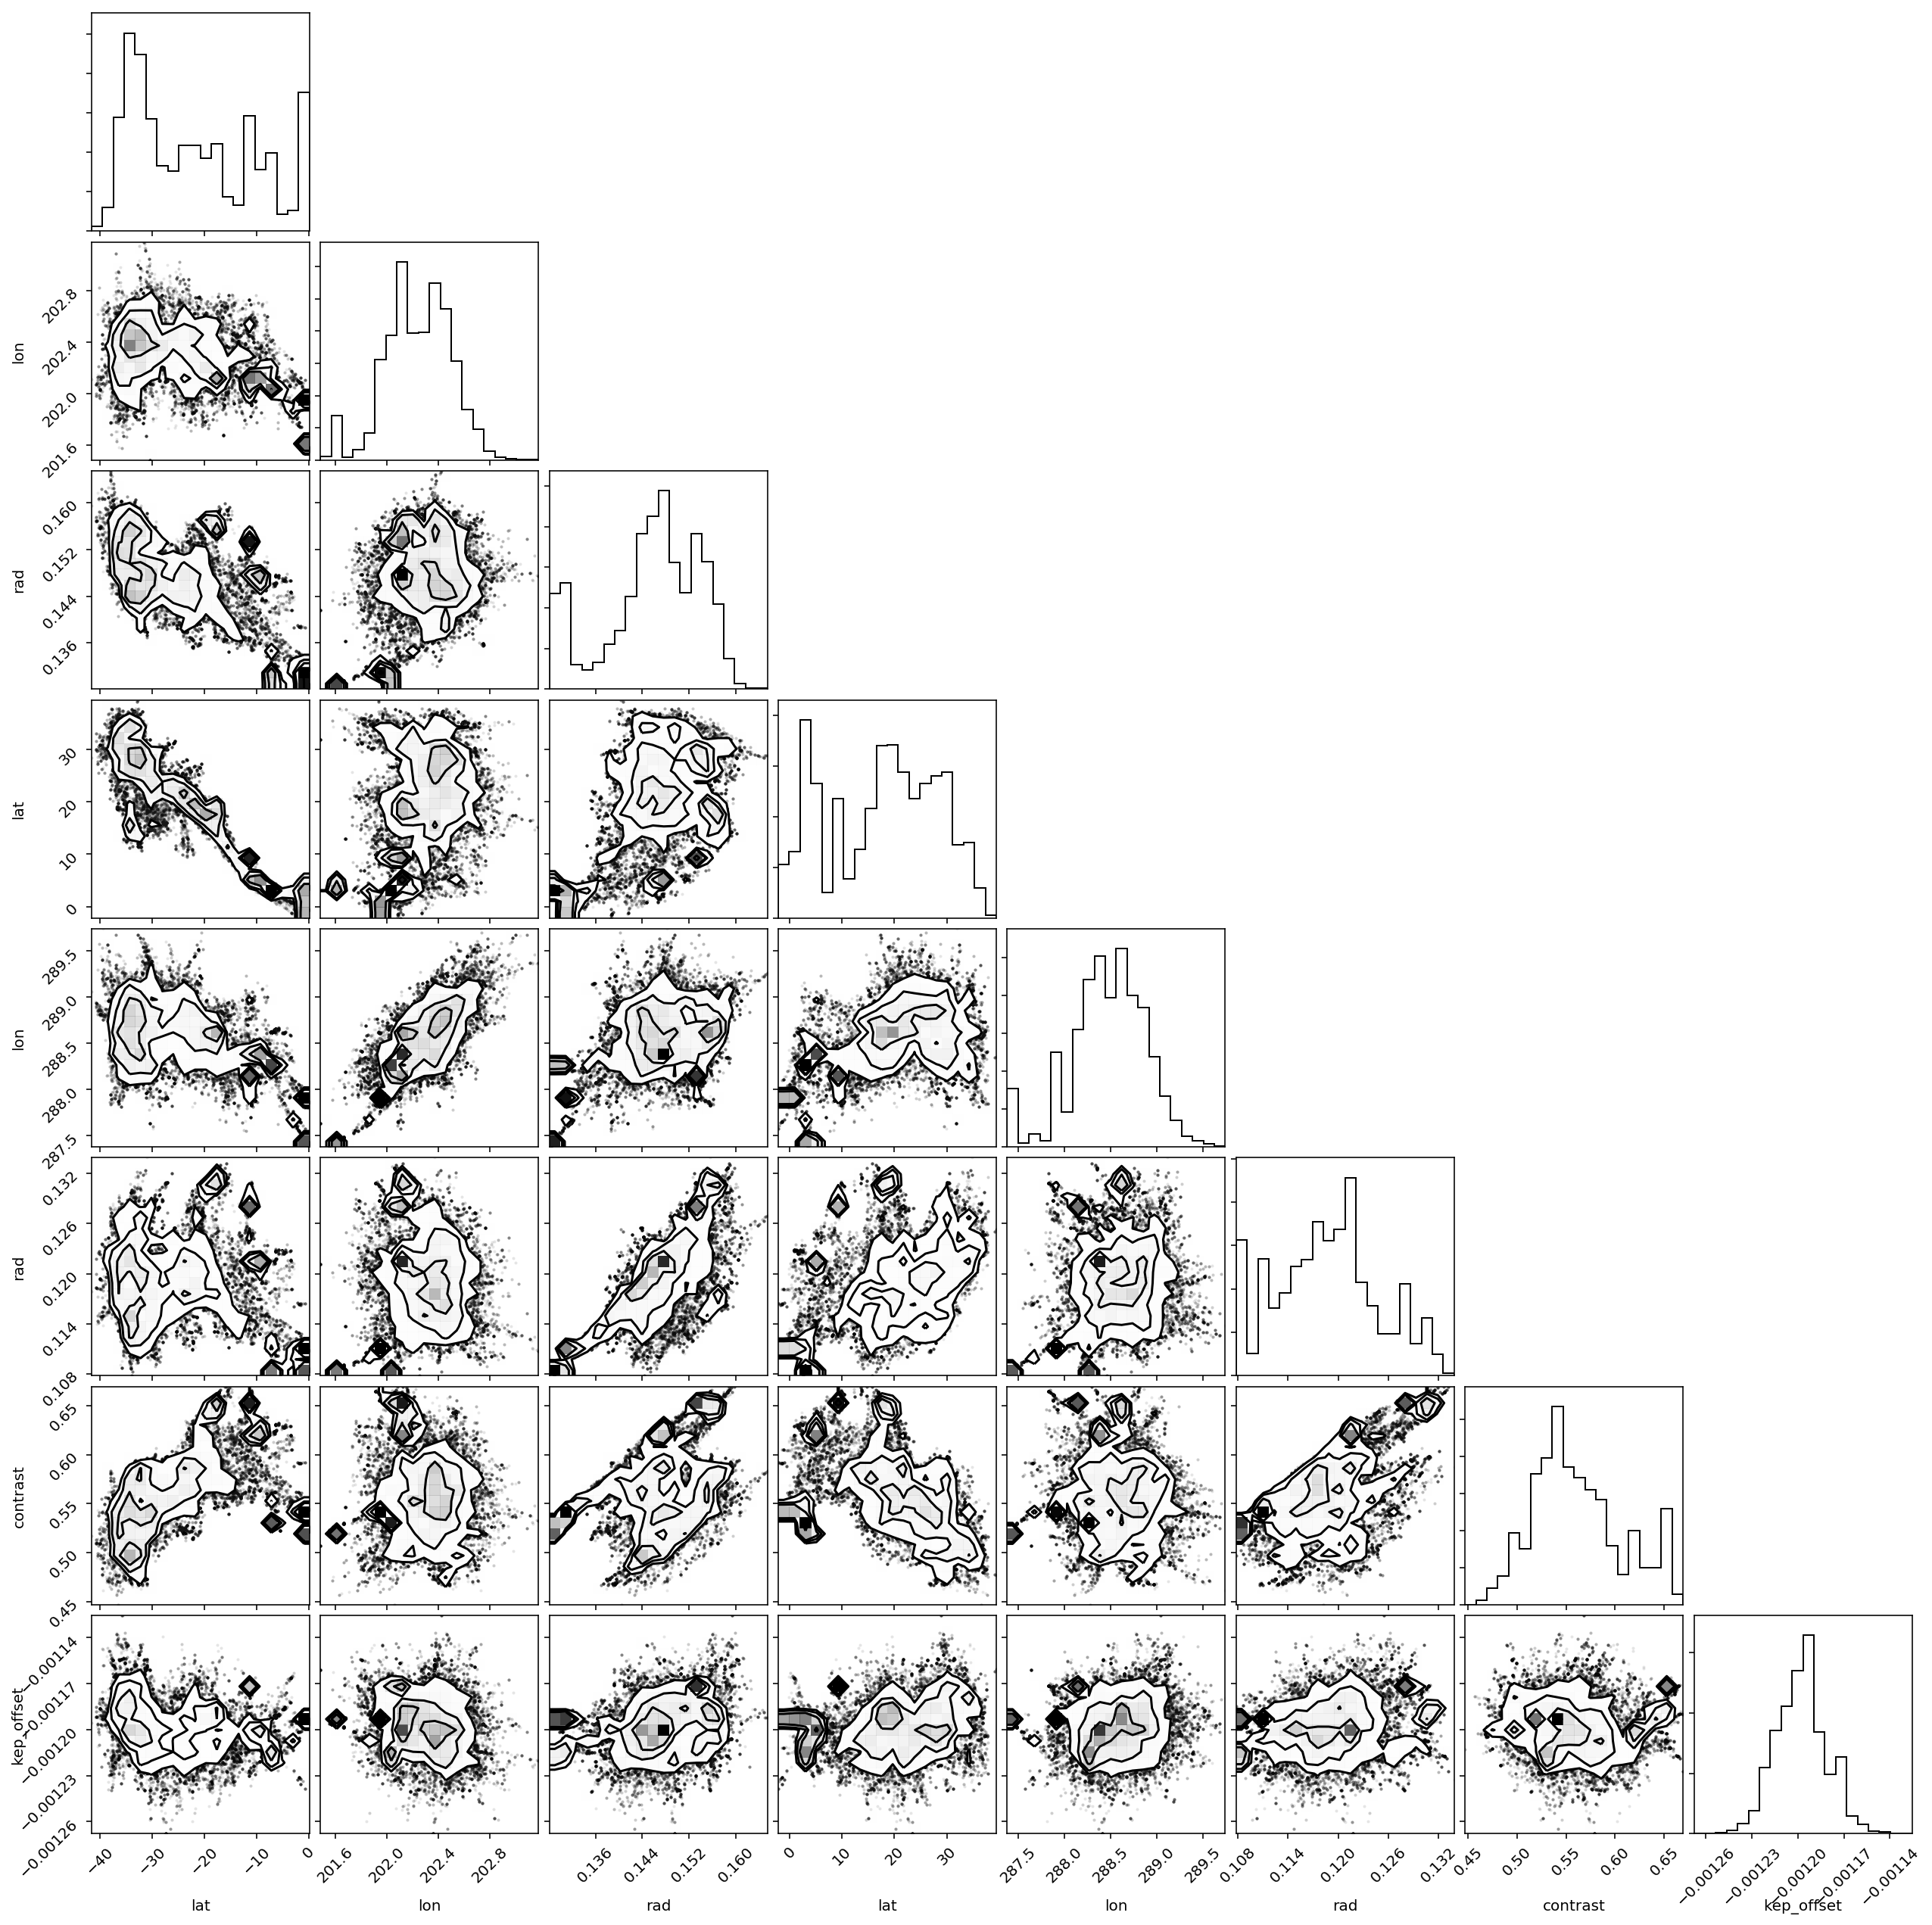

In [109]:
from corner import corner

corner(samples, labels=labels)

plt.savefig('corner_k296.png', bbox_inches='tight', dpi=250)
plt.show()

Text(0.5,0,'radii')

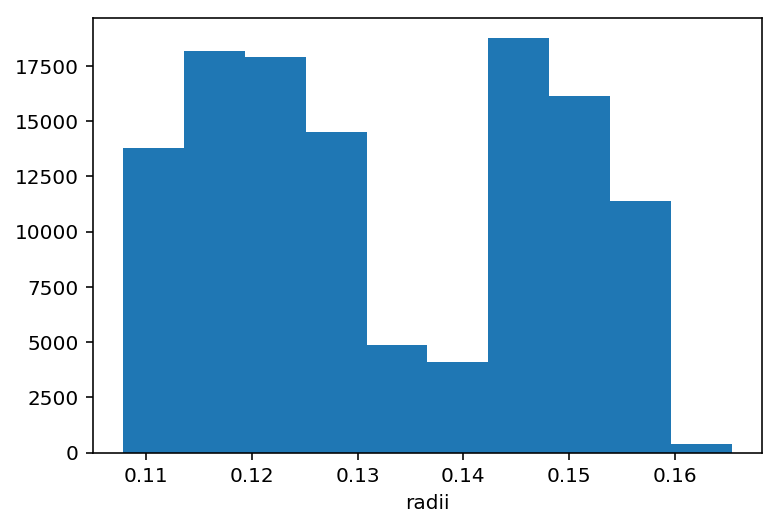

In [85]:
plt.hist(samples[:, 2::3].ravel())
plt.xlabel('radii')

In [92]:
np.savetxt("k296_spotmodel_posteriors.txt", samples)

In [87]:
#samples = np.loadtxt("trappist1_spotmodel_posteriors.txt")

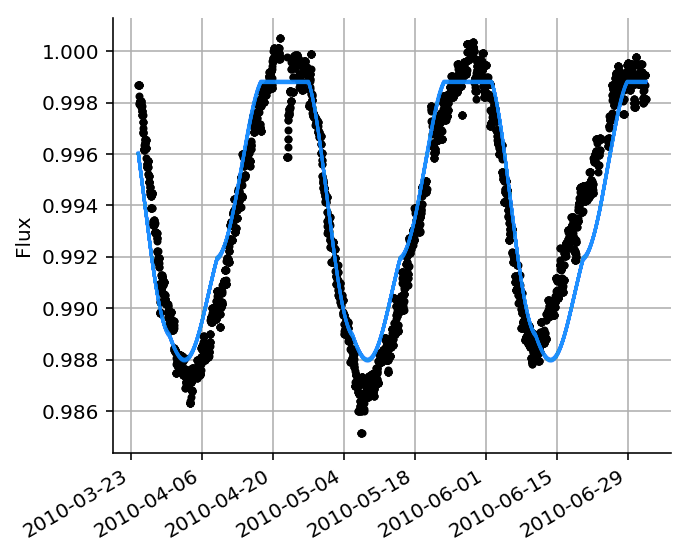

In [93]:
from astropy.time import Time

plt.figure(figsize=(5, 4))
# plt.plot_date(Time(chunk_time, format='jd').plot_date, 
#               chunk_flux, ms=0, ls='-', alpha=0.6, color='gray')

plt.plot_date(Time(chunk_time, format='jd').plot_date, chunk_flux, '.k', lw=2)

for i in np.random.randint(0, samples.shape[0], 200):
    plt.plot_date(Time(chunk_time, format='jd').plot_date, 
                  model(samples[i, :], chunk_time), ms=0, ls='-', alpha=0.05, color='DodgerBlue')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.ylabel('Flux')
#plt.xlim([Time('2017-01-16').plot_date, Time('2017-01-28').plot_date])
plt.savefig('model_kepler296_darkspots.pdf', bbox_inches='tight')
plt.show()

In [102]:
typical_contrast = np.median(samples[:, -2])

kepler_wavelengths, kepler_trans = np.loadtxt('../libra/data/filters/kepler_response_hires1.txt', unpack=True)
kepler_wavelengths = kepler_wavelengths * u.nm
#np.trapz()

from astropy.modeling.blackbody import blackbody_lambda

def residual(p):
    contrast = (1 - np.trapz(blackbody_lambda(kepler_wavelengths, p[0]).value * kepler_trans, kepler_wavelengths.value) / 
                np.trapz(blackbody_lambda(kepler_wavelengths, 3740).value * kepler_trans, kepler_wavelengths.value) )
    return abs(contrast - typical_contrast)
from scipy.optimize import fmin_powell

result = fmin_powell(residual, [3500])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 189


In [104]:
3740 - result

439.25200640096955

In [105]:
result

array(3300.7479935990305)